<a href="https://colab.research.google.com/github/jiheddachraoui/Covid19-ultrasound-Compressed-video-based-Frame-level-Scoring/blob/main/Max%2BMin_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scoring using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [197]:
# basics
import sys
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import cv2
import pickle 

import shutil
# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.utils import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.utils import  load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_auc_score
import keras.backend
import os
import random
import time
import datetime
from tensorflow.python.framework import ops
import inspect
import gc

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## utility functions

In [198]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today() 

In [199]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
   
    ops.reset_default_graph()
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [200]:
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

## code


In [201]:
batch_size = 4

input_directory = "/content/gdrive/MyDrive/Dataset/data2/"
output_directory = "/content/gdrive/MyDrive/Dataset/output/"

train_path = input_directory + r"train"
val_path = input_directory + r"valid"
test_path = input_directory + r"test"

figure_directory = "output/figures" 
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"


Removing empty folder: /content/gdrive/MyDrive/Dataset/output/models/2023-01-10 14-27-13


In [202]:
reset_graph()
reset_callbacks()

### preprosessing

In [204]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
#tf.set_random_seed(seed_value)
tf.random.set_seed(seed_value)
# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [205]:
hyper_dimension = 331

hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
#hyper_mode = 'grayscale'
#imagesize=(688, 1760, 3)

In [206]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.02,
                                   zoom_range = 0.02, 
                                   horizontal_flip = False)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    color_mode="rgb",
                                                    target_size = (333,333), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 color_mode="rgb",
                                                    target_size = (333,333), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 color_mode="rgb",
                                                    target_size = (333,333), # image height , image width
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)

test_generator.reset()

Found 151 images belonging to 4 classes.
Found 69 images belonging to 4 classes.
Found 26 images belonging to 4 classes.


In [207]:
x,y = next(train_generator)
x.shape

(4, 333, 333, 3)

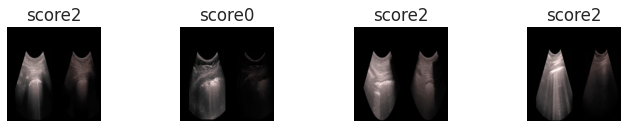

In [208]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
 
 
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(batch_size):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

## Model

In [209]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.resnet.ResNet50(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(333, 333,3),
                     
                     )
 
base_model.trainable=True
for layer in base_model.layers:
        layer.trainable=True
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
 
model = tf.keras.Sequential([
        base_model,  
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(renorm=True),
        #tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [210]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [211]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 11, 11, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 247808)            0         
                                                                 
 dense (Dense)               (None, 1000)              247809000 
                                                                 
 dense_1 (Dense)             (None, 512)               512512    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 120)               1

In [244]:
model = keras.models.load_model("/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_4.h5")
#/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_Max+Min11.h5
#/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_4.h5

In [245]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
checkpoint=checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_Max+Min{epoch}.h5",
   save_best_only=True,
    verbose=1
)
callbacks=[early,checkpoint]

In [ ]:

epochs=100
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

print("start Model Trainning", date_time(1))
# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks=callbacks)


print("Completed Model Trainning", date_time(1))

start Model Trainning Timestamp: 2023-01-10 16:59:03
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.5380 - auc_1: 0.6167 
Epoch 1: val_loss improved from inf to 3.11491, saving model to /content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_Max+Min1.h5
37/37 [==============================] - 589s 15s/step - loss: 1.5380 - auc_1: 0.6167 - val_loss: 3.1149 - val_auc_1: 0.4605
Epoch 2/100
 7/37 [====>.........................] - ETA: 6:03 - loss: 1.4077 - auc_1: 0.4904

In [215]:
model.save("/content/gdrive/MyDrive/Dataset/output/models/Modelmax+min2.h5")

In [216]:
#model = keras.models.load_model("/content/gdrive/MyDrive/Dataset/output/checkpoints/my_model_Max+Min11.h5")

## Visualization

In [ ]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    #print(list(cnn_model.history.keys()))
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[1]
    val_auc_name = list(cnn_model.history.keys())[3]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps = len(test_generator))
    print(Y_pred)
   
    #y_pred = (Y_pred > 0.5).T[0]
    y_pred = np.argmax(Y_pred, axis=1)
    print(y_pred)
    y_pred_prob = Y_pred.T[0]
    
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3])
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    #print(counts)
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [[f'{names[i]}\n{percentages[i]}' for i in range(len(names))] for j in range(len(cm))]
    #print(labels)
    #labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['socre0', 'socre1','socre2','socre3']
    #print(cm)
    #print(labels)
    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True)
    
  
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout();
    
    ## Summary Statistics
    
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    precision = np.mean(precision)  
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    recall = np.mean(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    TN = np.sum(np.diag(cm)) - np.sum(cm)
    FP = np.sum(cm, axis=0) - np.diag(cm)
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    specificity = np.mean(specificity)
    
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)
    

In [ ]:
create_charts(model, history)

In [ ]:
# store results
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
 
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
'''
accuracy_score = model.evaluate(test_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])'''
metrics = []
n_repeats=1
# Run the evaluation multiple times
for i in range(n_repeats):
    # Evaluate the model on the test set
    accuracy_score = model.evaluate(test_generator)
    print(accuracy_score)
    print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
    
    print("Loss: ",accuracy_score[0])
    metrics.append(accuracy_score)

# Convert the list of metrics to a Numpy array
metrics = np.array(metrics)

# Calculate the mean and standard deviation of the evaluation metrics
mean = np.mean(metrics, axis=0)
std = np.std(metrics, axis=0)

# Print the mean and standard deviation of the evaluation metrics
print(f'Mean: {mean}')
print(f'Standard Deviation: {std}')

In [ ]:
test_img_path = "/content/gdrive/MyDrive/Dataset/data2/test/score0/convex_1048_1126_8.jpg"
 
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (333, 333)).reshape(-1, 333, 333, 3)/255
 
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [ ]:
predictions = []
images=[]
for root, dirs, files in os.walk(test_path, topdown=False):
   for image in files:
      image=os.path.join(root, image)
      images.append(image)
      img = tf.keras.preprocessing.image.load_img(image)
      img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.smart_resize(img, (240,240))
      img = tf.reshape(img, (-1, 240,240, 3))
      prediction = model.predict(img)
      predictions.append(np.argmax(prediction))
sample=pd.DataFrame(images)  


my_submission = pd.DataFrame({'image_id': images, 'label':  predictions})
if os.path.exists('/content/gdrive/MyDrive/Dataset/output/submission.csv'):
  os.remove('/content/gdrive/MyDrive/Dataset/output/submission.csv')
my_submission.to_csv('/content/gdrive/MyDrive/Dataset/output/submission.csv', index=False)
 
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output
y_true = test_generator.classes
print(y_true)
accuracy = np.mean(y_true == predictions)
print('auc= ',accuracy)
cr = classification_report(y_true, predictions)
print('cr= ',cr)
